In [87]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import operator
import joblib
import random

In [95]:
from sklearn.ensemble import RandomForestClassifier
import mnist

In [46]:
def pre_process_image(img, skip_dilate=False):
    
    # reduce noise in thresholding algorithm via Gaussian Blur
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    
    # in order to successfully extract the grid, we need to invert the colors
    proc = cv2.bitwise_not(proc, proc)
    
    # dilation: We need to use dilation as while using Gaussian Thresholding we reduced noise which in
    # turn lead shrinking of our object. So we need to dilate it.
    if not skip_dilate:
        kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
        proc = cv2.dilate(proc, kernel)
    return proc

In [3]:
def find_corners(img, ind):
    
    # ramer doughlas peucker algorithm
    
    
    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True) 
    polygon = contours[ind] 

    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

    return polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]

In [2]:
def crop_and_warp(img, crop_rect):
    """Crops and warps a rectangular section from an image into a square of similar size."""

    
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]    
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')
    
    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])

    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')
    m = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, m, (int(side), int(side)))

In [6]:
def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))

In [5]:
def infer_grid(img):
    squares = []
    side = img.shape[:1]
    side = side[0] / 9
    for j in range(9):
        for i in range(9):
            p1 = (i * side, j * side)
            p2 = ((i + 1) * side, (j + 1) * side)
            squares.append((p1, p2))
    return squares

In [77]:
def get_digits(img, squares, size):
    digits = []
    img = pre_process_image(img.copy(), skip_dilate=True)
    for square in squares:
        digits.append(extract_digit(img, square, size))
    return digits

In [8]:
def extract_digit(img, rect, size):
    digit = img[int(rect[0][1]):int(rect[1][1]), int(rect[0][0]):int(rect[1][0])]
    h, w = digit.shape[:2]
    margin = int(np.mean([h, w]) / 2.5)
    _, bbox, seed = find_largest_feature(digit, [margin, margin], [w - margin, h - margin])
    digit = digit[int(bbox[0][1]):int(bbox[1][1]), int(bbox[0][0]):int(bbox[1][0])]
    w = bbox[1][0] - bbox[0][0]
    h = bbox[1][1] - bbox[0][1]
    if w > 0 and h > 0 and (w * h) > 100 and len(digit) > 0:
        return scale_and_centre(digit, size, 4)
    else:
        return np.zeros((size, size), np.uint8)

In [10]:
def find_largest_feature(inp_img, scan_tl=None, scan_br=None):
    img = inp_img.copy()
    height, width = img.shape[:2]
    max_area = 0
    seed_point = (None, None)
    if scan_tl is None:
        scan_tl = [0, 0]
    if scan_br is None:
        scan_br = [width, height]

    for x in range(scan_tl[0], scan_br[0]):
        for y in range(scan_tl[1], scan_br[1]):
            if img.item(y, x) == 255 and x < width and y < height:
                area = cv2.floodFill(img, None, (x, y), 64)
                if area[0] > max_area:
                    max_area = area[0]
                    seed_point = (x, y)
    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 255 and x < width and y < height:
                cv2.floodFill(img, None, (x, y), 64)

    mask = np.zeros((height + 2, width + 2), np.uint8)

    if all([p is not None for p in seed_point]):
        cv2.floodFill(img, mask, seed_point, 255)

    top, bottom, left, right = height, 0, width, 0

    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 64:
                cv2.floodFill(img, mask, (x, y), 0)

            if img.item(y, x) == 255:
                top = y if y < top else top
                bottom = y if y > bottom else bottom
                left = x if x < left else left
                right = x if x > right else right

    bbox = [[left, top], [right, bottom]]
    return img, np.array(bbox, dtype='float32'), seed_point

In [9]:
def show_digits(digits, colour=255):
    rows = []
    with_border = [cv2.copyMakeBorder(img.copy(), 1, 1, 1, 1, cv2.BORDER_CONSTANT, None, colour) for img in digits]
    for i in range(9):
        row = np.concatenate(with_border[i * 9:((i + 1) * 9)], axis=1)
        rows.append(row)
    return np.concatenate(rows)

In [11]:
def scale_and_centre(img, size, margin=0, background=0):
    h, w = img.shape[:2]

    def centre_pad(length):
        if length % 2 == 0:
            side1 = int((size - length) / 2)
            side2 = side1
        else:
            side1 = int((size - length) / 2)
            side2 = side1 + 1
        return side1, side2

    def scale(r, x):
        return int(r * x)

    if h > w:
        t_pad = int(margin / 2)
        b_pad = t_pad
        ratio = (size - margin) / h
        w, h = scale(ratio, w), scale(ratio, h)
        l_pad, r_pad = centre_pad(w)
    else:
        l_pad = int(margin / 2)
        r_pad = l_pad
        ratio = (size - margin) / w
        w, h = scale(ratio, w), scale(ratio, h)
        t_pad, b_pad = centre_pad(h)

    img = cv2.resize(img, (w, h))
    img = cv2.copyMakeBorder(img, t_pad, b_pad, l_pad, r_pad, cv2.BORDER_CONSTANT, None, background)
    return cv2.resize(img, (size, size))

In [64]:
def predict_image(image):
    # source: https://becominghuman.ai/image-processing-sudokuai-opencv-45380715a629
 
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    process = pre_process_image(img.copy(), skip_dilate=True)
    # source: https://becominghuman.ai/sudoku-and-cell-extraction-sudokuai-opencv-38b603066066
    
    # sudoku extraction
    polygons = []
    flag = 1
    for i in range(4):
        top_l, top_r, bottom_r, bottom_l  = find_corners(process, i)
        
        # in order to crop the image, we need to know the dimensions of the sudoku.
        width_A = np.sqrt(((bottom_r[0] - bottom_l[0]) ** 2) + ((bottom_r[1] - bottom_l[1]) ** 2))
        width_B = np.sqrt(((top_r[0] - top_l[0]) ** 2) + ((top_r[1] - top_l[1]) ** 2))
        width = max(int(width_A), int(width_B))

        height_A = np.sqrt(((top_r[0] - bottom_r[0]) ** 2) + ((top_r[1] - bottom_r[1]) ** 2))
        height_B = np.sqrt(((top_l[0] - bottom_l[0]) ** 2) + ((top_l[1] - bottom_l[1]) ** 2))
        height = max(int(height_A), int(height_B))

        if flag and (abs(width_A - width_B) < width * 0.2 or abs(height_A - height_B) < height * 0.2):
            et = width * height * 0.68
            h = height * 0.3
            w = width * 0.3
            flag = 0
        elif flag:
            et = width * height * 0.68
            h = height * 0.3
            w = width * 0.3

        if i > 0 and (abs(width_A - width_B) > w or abs(height_A - height_B) > h or abs(height - width) > 
                      width * 0.2 or width*height < et):
            continue
        else:
            polygons.append([top_l, top_r, bottom_r, bottom_l])

        # we need to construct dimensions for the cropped image
        dimensions = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype="float32")
        # convert to numpy format
        ordered_corners = [top_l, top_r, bottom_r, bottom_l]
        ordered_corners = np.array(ordered_corners , dtype="float32")
        
        # calculate the perspective transform matrix and warp
        # the perspective to grab the screen
        res = crop_and_warp(img, ordered_corners)
        
    dst = np.zeros(img.shape)    
    mask = cv2.fillPoly(dst, np.array( [[p[0], p[1], p[2], p[3]] for p in polygons], dtype=np.int32 ), (255,255,255))
    return mask, res

In [82]:
def preprocess_table(sudoku_table):
    squares = infer_grid(sudoku_table_img)
    digits = get_digits(sudoku_table_img, squares, 28)
    img = show_digits(digits)
    return img

In [86]:
def recognize_digits(img_table, clf):
    sudoku_digits = np.zeros((9,9))
    for i in range(9):
        for j in range(9):
            image = final_image[i*30:(i+1)*30,j*30:(j+1)*30]
            image = image[1:29,1:29]
            image = cv2.resize(image, (28,28))
            kernel = np.ones((2,2))
            image = cv2.dilate(image, kernel, iterations=2)
            image = cv2.erode(image, kernel, iterations=2)
            if image.sum() > 10000:
                features_test = np.array([image.ravel()])
                sudoku_digits[i][j] = clf.predict(features_test)[0]
            else:
                sudoku_digits[i][j] = -1
    return sudoku_digits

In [31]:
image = cv2.imread("data/train_0.jpg")

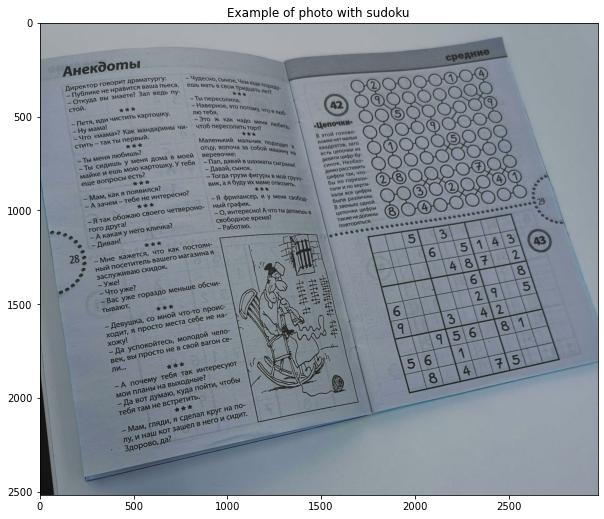

In [53]:
plt.figure(figsize=(10, 10))
plt.title('Example of photo with sudoku')
plt.imshow(image)


### 1. Extracting sudoku table from photo

In [65]:
mask, sudoku_table_img = predict_image(image)

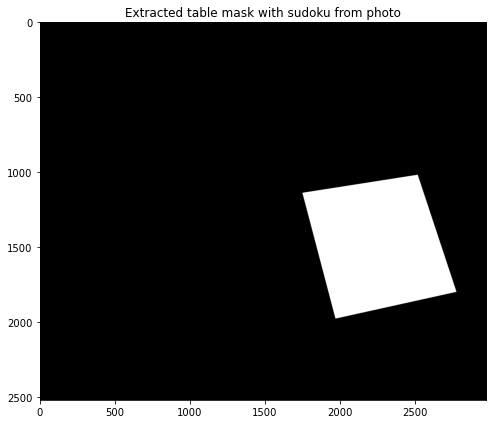

In [62]:
plt.figure(figsize=(8,8))
plt.title('Extracted table mask with sudoku from photo')
plt.imshow(mask, cmap='gray')

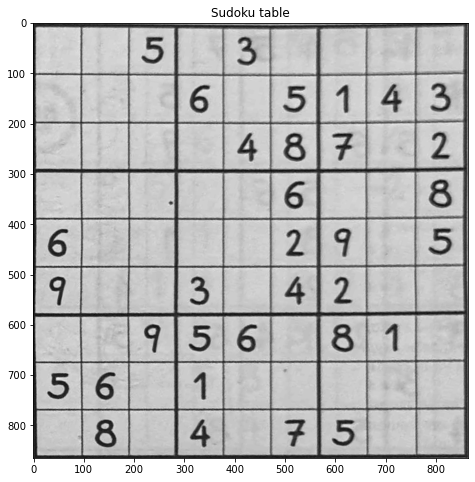

In [63]:
plt.figure(figsize=(8, 8))
plt.title('Sudoku table')
plt.imshow(sudoku_table_img, cmap='gray')

### 2. Training model for recognizing digits

### 3. Recognizing digits on table

In [84]:
final_img = preprocess_table(sudoku_table_img)